In [1]:
"""
Filename: odu.py
Authors: Thomas Sargent, John Stachurski
Solves the "Offer Distribution Unknown" Model by value function
iteration and a second faster method discussed in the corresponding
quantecon lecture.
"""
from textwrap import dedent
from scipy.interpolate import LinearNDInterpolator
from scipy.integrate import fixed_quad
from scipy.stats import beta as beta_distribution
from scipy import interp
from numpy import maximum as npmax
import numpy as np


class SearchProblem(object):
    """
    A class to store a given parameterization of the "offer distribution
    unknown" model.
    Parameters
    ----------
    beta : scalar(float), optional(default=0.95)
        The discount parameter
    c : scalar(float), optional(default=0.6)
        The unemployment compensation
    F_a : scalar(float), optional(default=1)
        First parameter of beta distribution on F
    F_b : scalar(float), optional(default=1)
        Second parameter of beta distribution on F
    G_a : scalar(float), optional(default=3)
        First parameter of beta distribution on G
    G_b : scalar(float), optional(default=1.2)
        Second parameter of beta distribution on G
    w_max : scalar(float), optional(default=2)
        Maximum wage possible
    w_grid_size : scalar(int), optional(default=40)
        Size of the grid on wages
    pi_grid_size : scalar(int), optional(default=40)
        Size of the grid on probabilities
    Attributes
    ----------
    beta, c, w_max : see Parameters
    w_grid : np.ndarray
        Grid points over wages, ndim=1
    pi_grid : np.ndarray
        Grid points over pi, ndim=1
    grid_points : np.ndarray
        Combined grid points, ndim=2
    F : scipy.stats._distn_infrastructure.rv_frozen
        Beta distribution with params (F_a, F_b), scaled by w_max
    G : scipy.stats._distn_infrastructure.rv_frozen
        Beta distribution with params (G_a, G_b), scaled by w_max
    f : function
        Density of F
    g : function
        Density of G
    pi_min : scalar(float)
        Minimum of grid over pi
    pi_max : scalar(float)
        Maximum of grid over pi
    """

    def __init__(self, beta=0.95, c=0.6, F_a=1, F_b=1, G_a=3, G_b=1.2,
                 w_max=2, w_grid_size=40, pi_grid_size=40):

        self.beta, self.c, self.w_max = beta, c, w_max
        self.F = beta_distribution(F_a, F_b, scale=w_max)
        self.G = beta_distribution(G_a, G_b, scale=w_max)
        self.f, self.g = self.F.pdf, self.G.pdf    # Density functions
        self.pi_min, self.pi_max = 1e-3, 1 - 1e-3  # Avoids instability
        self.w_grid = np.linspace(0, w_max, w_grid_size)
        self.pi_grid = np.linspace(self.pi_min, self.pi_max, pi_grid_size)
        x, y = np.meshgrid(self.w_grid, self.pi_grid)
        self.grid_points = np.column_stack((x.ravel(1), y.ravel(1)))

    def __repr__(self):
        m = "SearchProblem(beta={b}, c={c}, F_a={fa}, F_b={fb}, G_a={ga}, "
        m += "G_b={gb}, w_max={wu}, w_grid_size={wgs}, pi_grid_size={pgs})"
        fa, fb = self.F.args
        ga, gb = self.G.args
        return m.format(b=self.beta, c=self.c, fa=fa, fb=fb, ga=ga,
                        gb=gb, wu=self.w_grid.max(),
                        wgs=self.w_grid.size, pgs=self.pi_grid.size)

    def __str__(self):
        m = """\
        SearchProblem (offer distribution unknown):
         - beta (discount factor)                          : {b:g}
         - c (unemployment compensation)                   : {c}
         - F (distribution F)                              : Beta({fa}, {fb:g})
         - G (distribution G)                              : Beta({ga}, {gb:g})
         - w bounds (bounds for wage offers)               : ({wl:g}, {wu:g})
         - w grid size (number of points in grid for wage) : {wgs}
         - pi bounds (bounds for probability of dist f)    : ({pl:g}, {pu:g})
         - pi grid size (number of points in grid for pi)  : {pgs}
        """
        fa, fb = self.F.args
        ga, gb = self.G.args
        return dedent(m.format(b=self.beta, c=self.c, fa=fa, fb=fb, ga=ga,
                               gb=gb,
                               wl=self.w_grid.min(), wu=self.w_grid.max(),
                               wgs=self.w_grid.size,
                               pl=self.pi_grid.min(), pu=self.pi_grid.max(),
                               pgs=self.pi_grid.size))

    def q(self, w, pi):
        """
        Updates pi using Bayes' rule and the current wage observation w.
        Returns
        -------
        new_pi : scalar(float)
            The updated probability
        """

        new_pi = 1.0 / (1 + ((1 - pi) * self.g(w)) / (pi * self.f(w)))

        # Return new_pi when in [pi_min, pi_max] and else end points
        new_pi = np.maximum(np.minimum(new_pi, self.pi_max), self.pi_min)

        return new_pi

    def bellman_operator(self, v):
        """
        The Bellman operator.  Including for comparison. Value function
        iteration is not recommended for this problem.  See the
        reservation wage operator below.
        Parameters
        ----------
        v : array_like(float, ndim=1, length=len(pi_grid))
            An approximate value function represented as a
            one-dimensional array.
        Returns
        -------
        new_v : array_like(float, ndim=1, length=len(pi_grid))
            The updated value function
        """
        # == Simplify names == #
        f, g, beta, c, q = self.f, self.g, self.beta, self.c, self.q

        vf = LinearNDInterpolator(self.grid_points, v)
        N = len(v)
        new_v = np.empty(N)

        for i in range(N):
            w, pi = self.grid_points[i, :]
            v1 = w / (1 - beta)
            integrand = lambda m: vf(m, q(m, pi)) * (pi * f(m)
                                                     + (1 - pi) * g(m))
            integral, error = fixed_quad(integrand, 0, self.w_max)
            v2 = c + beta * integral
            new_v[i] = max(v1, v2)

        return new_v

    def get_greedy(self, v):
        """
        Compute optimal actions taking v as the value function.
        Parameters
        ----------
        v : array_like(float, ndim=1, length=len(pi_grid))
            An approximate value function represented as a
            one-dimensional array.
        Returns
        -------
        policy : array_like(float, ndim=1, length=len(pi_grid))
            The decision to accept or reject an offer where 1 indicates
            accept and 0 indicates reject
        """
        # == Simplify names == #
        f, g, beta, c, q = self.f, self.g, self.beta, self.c, self.q

        vf = LinearNDInterpolator(self.grid_points, v)
        N = len(v)
        policy = np.zeros(N, dtype=int)

        for i in range(N):
            w, pi = self.grid_points[i, :]
            v1 = w / (1 - beta)
            integrand = lambda m: vf(m, q(m, pi)) * (pi * f(m) +
                                                     (1 - pi) * g(m))
            integral, error = fixed_quad(integrand, 0, self.w_max)
            v2 = c + beta * integral
            policy[i] = v1 > v2  # Evaluates to 1 or 0

        return policy

    def res_wage_operator(self, phi):
        """
        Updates the reservation wage function guess phi via the operator
        Q.
        Parameters
        ----------
        phi : array_like(float, ndim=1, length=len(pi_grid))
            This is reservation wage guess
        Returns
        -------
        new_phi : array_like(float, ndim=1, length=len(pi_grid))
            The updated reservation wage guess.
        """
        # == Simplify names == #
        beta, c, f, g, q = self.beta, self.c, self.f, self.g, self.q
        # == Turn phi into a function == #
        phi_f = lambda p: interp(p, self.pi_grid, phi)

        new_phi = np.empty(len(phi))
        for i, pi in enumerate(self.pi_grid):
            def integrand(x):
                "Integral expression on right-hand side of operator"
                return npmax(x, phi_f(q(x, pi))) * (pi*f(x) + (1 - pi)*g(x))
            integral, error = fixed_quad(integrand, 0, self.w_max)
            new_phi[i] = (1 - beta) * c + beta * integral

        return new_phi

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            1.322e+00      4.971e+01         
10           1.717e-01      1.043e+02         
15           3.170e-02      1.618e+02         
20           5.626e-03      2.140e+02         
25           1.035e-03      2.620e+02         


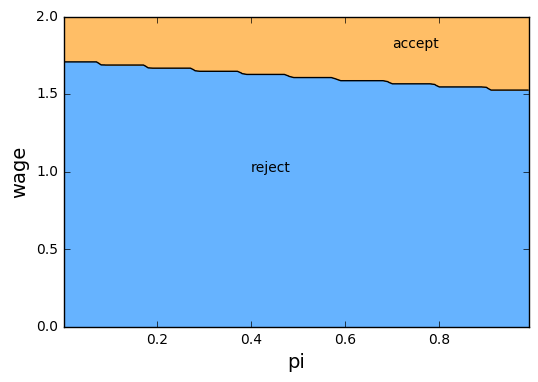

In [3]:
"""
Filename: odu_vfi_plots.py
Authors: John Stachurski and Thomas Sargent
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
from scipy.interpolate import LinearNDInterpolator
import numpy as np
from quantecon import compute_fixed_point
#from odu import SearchProblem


sp = SearchProblem(w_grid_size=100, pi_grid_size=100)
v_init = np.zeros(len(sp.grid_points)) + sp.c / (1 - sp.beta)
v = compute_fixed_point(sp.bellman_operator, v_init)
policy = sp.get_greedy(v)

# Make functions from these arrays by interpolation
vf = LinearNDInterpolator(sp.grid_points, v)
pf = LinearNDInterpolator(sp.grid_points, policy)

pi_plot_grid_size, w_plot_grid_size = 100, 100
pi_plot_grid = np.linspace(0.001, 0.99, pi_plot_grid_size)
w_plot_grid = np.linspace(0, sp.w_max, w_plot_grid_size)

# plot_choice = 'value_function'
plot_choice = 'policy_function'

if plot_choice == 'value_function':
    Z = np.empty((w_plot_grid_size, pi_plot_grid_size))
    for i in range(w_plot_grid_size):
        for j in range(pi_plot_grid_size):
            Z[i, j] = vf(w_plot_grid[i], pi_plot_grid[j])
    fig, ax = plt.subplots()
    ax.contourf(pi_plot_grid, w_plot_grid, Z, 12, alpha=0.6, cmap=cm.jet)
    cs = ax.contour(pi_plot_grid, w_plot_grid, Z, 12, colors="black")
    ax.clabel(cs, inline=1, fontsize=10)
    ax.set_xlabel('pi', fontsize=14)
    ax.set_ylabel('wage', fontsize=14)
else:
    Z = np.empty((w_plot_grid_size, pi_plot_grid_size))
    for i in range(w_plot_grid_size):
        for j in range(pi_plot_grid_size):
            Z[i, j] = pf(w_plot_grid[i], pi_plot_grid[j])
    fig, ax = plt.subplots()
    ax.contourf(pi_plot_grid, w_plot_grid, Z, 1, alpha=0.6, cmap=cm.jet)
    ax.contour(pi_plot_grid, w_plot_grid, Z, 1, colors="black")
    ax.set_xlabel('pi', fontsize=14)
    ax.set_ylabel('wage', fontsize=14)
    ax.text(0.4, 1.0, 'reject')
    ax.text(0.7, 1.8, 'accept')

plt.show()

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            2.829e-02      3.120e-01         
10           5.174e-03      5.890e-01         
15           9.652e-04      8.760e-01         


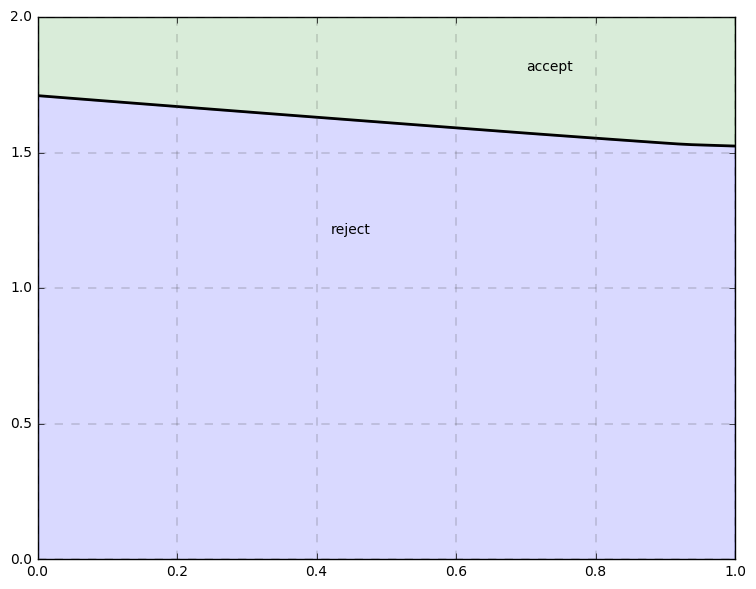

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from quantecon import compute_fixed_point
#from odu import SearchProblem
sp = SearchProblem(pi_grid_size=50)

phi_init = np.ones(len(sp.pi_grid)) 
w_bar = compute_fixed_point(sp.res_wage_operator, phi_init)

fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(sp.pi_grid, w_bar, linewidth=2, color='black')
ax.set_ylim(0, 2)
ax.grid(axis='x', linewidth=0.25, linestyle='--', color='0.25')
ax.grid(axis='y', linewidth=0.25, linestyle='--', color='0.25')
ax.fill_between(sp.pi_grid, 0, w_bar, color='blue', alpha=0.15)
ax.fill_between(sp.pi_grid, w_bar, 2, color='green', alpha=0.15)
ax.text(0.42, 1.2, 'reject')
ax.text(0.7, 1.8, 'accept')
plt.show()

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            2.829e-02      1.994e-01         
10           5.174e-03      3.858e-01         
15           9.652e-04      5.896e-01         
date = 0
date = 20
date = 40
date = 60
date = 80
date = 100
date = 120
date = 140
date = 160
date = 180
date = 200
date = 220
date = 240
date = 260
date = 280
date = 300
date = 320
date = 340
date = 360
date = 380
date = 400
date = 420
date = 440
date = 460
date = 480
date = 500
date = 520
date = 540
date = 560
date = 580


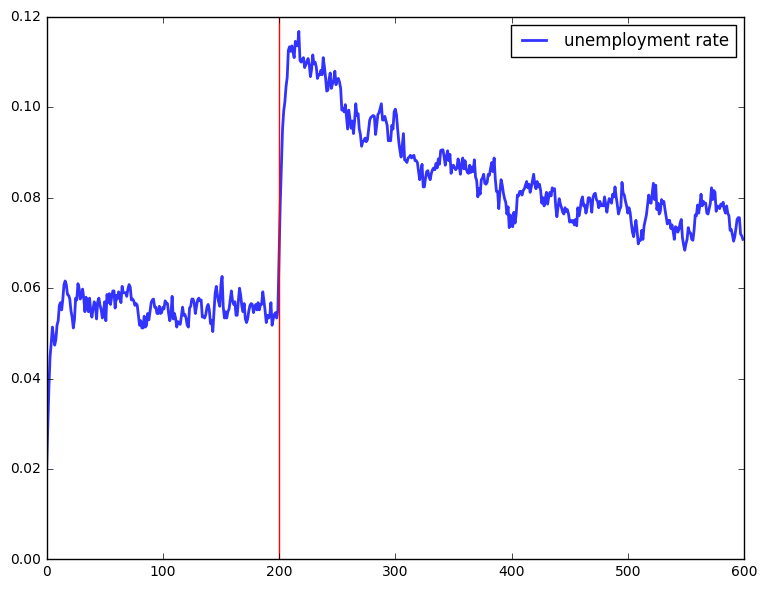

In [29]:
from scipy import interp
# Set up model and compute the function w_bar
sp = SearchProblem(pi_grid_size=50, F_a=1, F_b=1)
pi_grid, f, g, F, G = sp.pi_grid, sp.f, sp.g, sp.F, sp.G
phi_init = np.ones(len(sp.pi_grid)) 
w_bar_vals = compute_fixed_point(sp.res_wage_operator, phi_init)
w_bar = lambda x: interp(x, pi_grid, w_bar_vals)


class Agent(object):
    """
    Holds the employment state and beliefs of an individual agent.
    """

    def __init__(self, pi=1e-3):
        self.pi = pi
        self.employed = 1

    def update(self, H):
        "Update self by drawing wage offer from distribution H."
        if self.employed == 0:
            w = H.rvs()
            if w >= w_bar(self.pi):
                self.employed = 1
            else:
                self.pi = 1.0 / (1 + ((1 - self.pi) * g(w)) / (self.pi * f(w)))


num_agents = 5000
separation_rate = 0.025  # Fraction of jobs that end in each period 
separation_num = int(num_agents * separation_rate)
agent_indices = list(range(num_agents))
agents = [Agent() for i in range(num_agents)]
sim_length = 600
H = G  # Start with distribution G
change_date = 200  # Change to F after this many periods

unempl_rate = []
for i in range(sim_length):
    if i % 20 == 0:
        print("date =", i)
    if i == change_date:
        H = F
    # Randomly select separation_num agents and set employment status to 0
    np.random.shuffle(agent_indices)
    separation_list = agent_indices[:separation_num]
    for agent_index in separation_list:
        agents[agent_index].employed = 0
    # Update agents
    for agent in agents:
        agent.update(H)
    employed = [agent.employed for agent in agents]
    unempl_rate.append(1 - np.mean(employed))

fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(unempl_rate, lw=2, alpha=0.8, label='unemployment rate')
ax.axvline(change_date, color="red")
ax.legend()
plt.show()

In [16]:
sp.F.cdf(np.linspace(0,2,11))

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

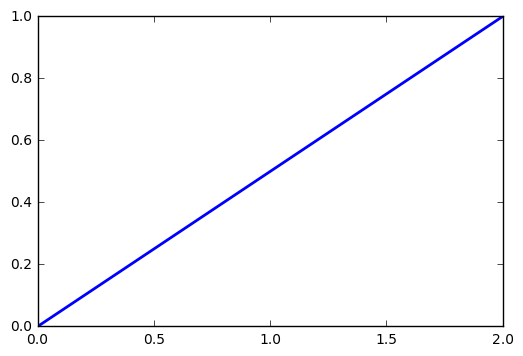

In [21]:
fig, ax = plt.subplots()
x=np.linspace(0,2,11)
y=sp.F.cdf(np.linspace(0,2,11))
ax.plot(x, y, 'b-', linewidth=2)
plt.show()

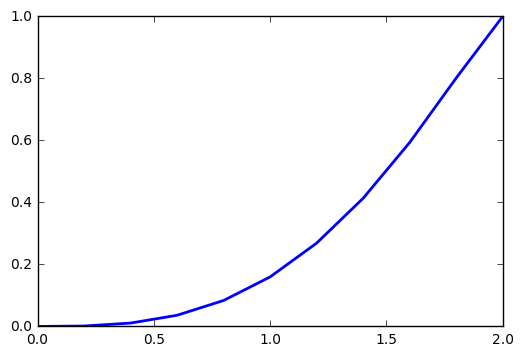

In [22]:
fig, ax = plt.subplots()
x=np.linspace(0,2,11)
y=sp.G.cdf(np.linspace(0,2,11))
ax.plot(x, y, 'b-', linewidth=2)
plt.show()

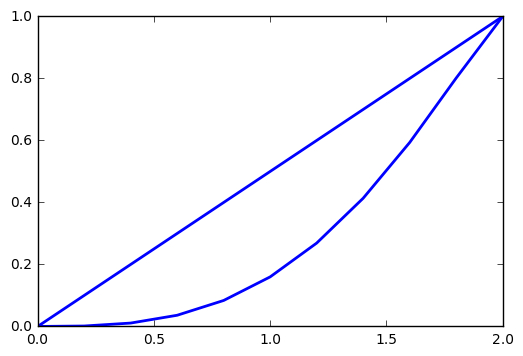

In [27]:
fig, ax = plt.subplots()
x=np.linspace(0,2,11)
y, z=sp.F.cdf(np.linspace(0,2,11)), sp.G.cdf(np.linspace(0,2,11))
ax.plot(x, y, 'b-', linewidth=2)
ax.plot(x, z, 'b-', linewidth=2)
plt.show()

This is a good example of the relation of first order stochastic domination.

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            2.829e-02      2.250e-01         
10           5.174e-03      4.280e-01         
15           9.652e-04      6.310e-01         
date = 0
date = 20
date = 40
date = 60
date = 80
date = 100
date = 120
date = 140
date = 160
date = 180
date = 200
date = 220
date = 240
date = 260
date = 280
date = 300
date = 320
date = 340
date = 360
date = 380
date = 400
date = 420
date = 440
date = 460
date = 480
date = 500
date = 520
date = 540
date = 560
date = 580


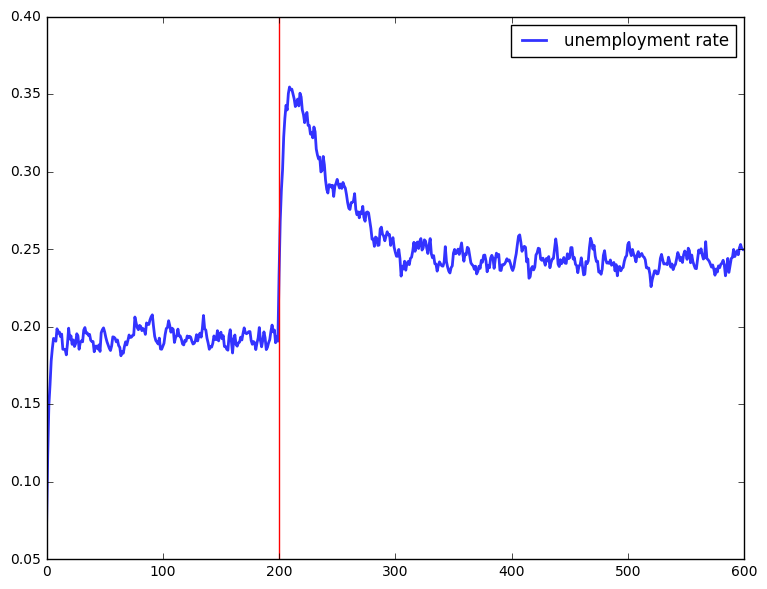

In [28]:
from scipy import interp
# Set up model and compute the function w_bar
sp = SearchProblem(pi_grid_size=50, F_a=1, F_b=1)
pi_grid, f, g, F, G = sp.pi_grid, sp.f, sp.g, sp.F, sp.G
phi_init = np.ones(len(sp.pi_grid)) 
w_bar_vals = compute_fixed_point(sp.res_wage_operator, phi_init)
w_bar = lambda x: interp(x, pi_grid, w_bar_vals)


class Agent(object):
    """
    Holds the employment state and beliefs of an individual agent.
    """

    def __init__(self, pi=1e-3):
        self.pi = pi
        self.employed = 1

    def update(self, H):
        "Update self by drawing wage offer from distribution H."
        if self.employed == 0:
            w = H.rvs()
            if w >= w_bar(self.pi):
                self.employed = 1
            else:
                self.pi = 1.0 / (1 + ((1 - self.pi) * g(w)) / (self.pi * f(w)))


num_agents = 5000
separation_rate = 0.1  # Fraction of jobs that end in each period 
separation_num = int(num_agents * separation_rate)
agent_indices = list(range(num_agents))
agents = [Agent() for i in range(num_agents)]
sim_length = 600
H = G  # Start with distribution G
change_date = 200  # Change to F after this many periods

unempl_rate = []
for i in range(sim_length):
    if i % 20 == 0:
        print("date =", i)
    if i == change_date:
        H = F
    # Randomly select separation_num agents and set employment status to 0
    np.random.shuffle(agent_indices)
    separation_list = agent_indices[:separation_num]
    for agent_index in separation_list:
        agents[agent_index].employed = 0
    # Update agents
    for agent in agents:
        agent.update(H)
    employed = [agent.employed for agent in agents]
    unempl_rate.append(1 - np.mean(employed))

fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(unempl_rate, lw=2, alpha=0.8, label='unemployment rate')
ax.axvline(change_date, color="red")
ax.legend()
plt.show()